# **Settings**

In [1]:
# Since I'm working in a project folder called "crm-project"
# I'm setting this notebook to that project folder as the working directory 

import os

current_working_dir = os.path.normpath(os.getcwd()).split(os.path.sep)[-1]

if current_working_dir != 'crm_project':
    os.chdir('..')

## Libraries

In [2]:
# Data wrangling & statistics
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection & ML
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from catboost import CatBoostClassifier

# Custom functions
from src.utils.metrics import false_positive_rate, false_negative_rate, auc_precision_recall, compute_metrics, prepare_cv_results

# Set transform output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

## Plot settings

In [3]:
# Customizing plot default behaviour, please refer to:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.75,
    palette=['#16a3ae', '#f69f38'], # Betsson colors ;)
    rc={
        'figure.figsize': (6,4),
        'axes.grid': True,
        'grid.alpha': .3,
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 30,
        'axes.labelpad': 15
    }
)

## Load datasets

In [4]:
# Load datasets, specifying the customer IDs as index
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')
df_customer_country = pd.read_csv('data/customer_country.csv', index_col='mk_CurrentCustomer')

# Convert date columns to date specifying the format (it's much faster when specifying it)
df_train['ScoreDate'] = pd.to_datetime(df_train['ScoreDate'], format='%d/%m/%Y %H:%M')

# Merging the datasets
# Note: Since there are no duplicated IDs (see next cells), so it's safe to merge it
df = df_train.join(df_customer_country, how='left')

# Show quantity of rows, columns, and first rows
print(df.shape)
display(df.head())

(55415, 270)


,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy


# **Feature Selection**

Let's first split the data into feature & target, train & test:

In [5]:
# Target & features
TARGET = 'target'

CATEGORICAL_FEATURES = ['country']
NUMERIC_FEATURES = df.drop(columns=['ScoreDate','country','target']).columns.tolist()
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# Split data into X,y
X = df[FEATURES]
y = df[TARGET]

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

## EDA feature selection

## Low-variance features

I'm removing the features with extremely low variance (constant and quasi-constant features):

In [6]:
# Instantiate variance-threshold class
sel_vt = VarianceThreshold(0.01)

# Fit transformer
sel_vt.fit(X_train[NUMERIC_FEATURES], y_train)

# Quasi-constant feature to drop:
print('Quasi-constant feature to drop:')
sel_vt.feature_names_in_[~np.isin(sel_vt.feature_names_in_, sel_vt.get_feature_names_out())]

Quasi-constant feature to drop:


array(['to_l1_l70', 'GI_total', 'SE_GI_wrt_days_70days'], dtype=object)

## Outliers

I'm capping (limiting) the most extreme outliers to the top 99.99 percentile. It should impact only highly extreme outliers. 

In [7]:
# See original stats
X_train[NUMERIC_FEATURES].describe(percentiles=[.25, .5, .75, .99, .999])

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
count,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,...,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000
mean,3.255955,3.157629,2.881485,2.693878,2.542926,2.550235,2.497180,2.496165,2.434675,2.359808,...,0.000023,105.427840,37.802648,16.235383,24.438577,9.609403,-0.594627,0.654493,-0.509361,-0.359499
std,2.208599,2.297427,2.383612,2.384328,2.374139,2.394017,2.387193,2.395295,2.390447,2.388709,...,0.004749,366.277608,178.374005,110.070719,127.263348,66.482279,6.888580,19.330696,7.864960,24.882021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
99%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.000000,2015.690000,927.000000,460.690000,620.690000,301.629956,4.000000,28.000000,6.000000,7.143176
99.9%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.000000,2909.000000,1953.000000,1598.394000,1622.690000,871.401199,47.000000,323.669000,54.669000,70.408568
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,1.000000,5737.000000,5015.000000,4158.000000,4158.000000,2741.840987,654.000000,1005.000000,872.000000,4531.044913


In [8]:
# Instantiate outlier capping class
sel_winsorizer = Winsorizer(capping_method='quantiles', tail='right', fold=0.0001) # 99.99

# Fit transformer
numeric_preprocessor = make_pipeline(sel_vt, sel_winsorizer)
numeric_preprocessor.fit(X_train[NUMERIC_FEATURES], y_train)

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.01)),
                ('winsorizer',
                 Winsorizer(capping_method='quantiles', fold=0.0001))])

In [9]:
# See stats after outlier winsorizing
df_without_outliers = numeric_preprocessor.fit_transform(X_train[NUMERIC_FEATURES], y_train)
df_without_outliers.describe(percentiles=[.25, .5, .75, .99, .999])

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,SE_GI_total_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
count,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,...,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000,44332.000000
mean,3.255955,3.157629,2.881485,2.693878,2.542926,2.550235,2.497180,2.496165,2.434675,2.359808,...,0.048881,105.290729,37.715410,16.182426,24.385620,9.570403,-0.608345,0.634865,-0.530546,-0.488127
std,2.208599,2.297427,2.383612,2.384328,2.374139,2.394017,2.387193,2.395295,2.390447,2.388709,...,0.359429,364.705816,176.564117,108.560855,125.963188,65.349003,5.923198,18.503564,6.301732,9.284258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
99%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,1.000000,2015.690000,927.000000,460.690000,620.690000,301.629956,4.000000,28.000000,6.000000,7.143176
99.9%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,5.000000,2909.000000,1953.000000,1598.394000,1622.690000,871.401199,47.000000,323.669000,54.669000,70.408568
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,10.000000,3400.517500,2963.109100,2504.862500,2504.862500,1346.286481,327.566900,679.968300,337.771100,617.681261


In [10]:
# If you want to see the upper bounding limit:

# fitted_winsorizer = numeric_preprocessor['winsorizer']
# fitted_winsorizer.right_tail_caps_

Note: I'm not removing outliers. Instead, I opted to cap (limit) the most extreme outliers to a maximum threshold acceptable. It's going to limit

## Correlated features

As assessed by the correlation plot in the EDA notebook, we have correlated features.  
We'll identify the correlated feature sets, and keep only the one with the highest variance.

In [11]:
# The ideal way to filter correlated features would be keeping the ones resulting in the highest recall for our model
# but it takes a lot of time to run, so I'm commenting this code to adopt another approach in the next cell

# # Use catboost as reference model to decide which correlated feature to keep
# clf = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, task_type='GPU', devices='0:1', silent=True)

# # Instantiate smart correlation class
# sel_smartcorr = SmartCorrelatedSelection(
#     method='spearman',
#     threshold=0.8,
#     missing_values='raise',
#     selection_method="model_performance",
#     estimator=clf,
#     scoring='recall',
#     cv=3,
# )

# # Apply smart correlation in the last step
# numeric_preprocessor = make_pipeline(sel_vt, sel_winsorizer, sel_smartcorr)
# # Fit transformer pipeline
# numeric_preprocessor.fit(X_train[NUMERIC_FEATURES], y_train)

In [12]:
# Instantiate smart correlation class (we'll keep the feature with the highest variance among the correlated ones)
sel_smartcorr = SmartCorrelatedSelection(
    method='spearman',
    threshold=0.95,
    missing_values='raise',
    selection_method="variance",
    estimator=None
)

# Apply smart correlation in the last step
numeric_preprocessor = make_pipeline(sel_vt, sel_winsorizer, sel_smartcorr)
# Fit transformer pipeline
numeric_preprocessor.fit(X_train[NUMERIC_FEATURES], y_train)

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.01)),
                ('winsorizer',
                 Winsorizer(capping_method='quantiles', fold=0.0001)),
                ('smartcorrelatedselection',
                 SmartCorrelatedSelection(method='spearman',
                                          missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.95))])

In [13]:
# Visualize correlated feature sets
sel_smartcorr_fitted = numeric_preprocessor.named_steps['smartcorrelatedselection']
sel_smartcorr_fitted.correlated_feature_sets_

[{'GOC_dist_gm_g7', 'GOC_ro_g7'},
 {'GOC_dist_gm_g6', 'GOC_ro_g6', 'GOC_to_g6'},
 {'GOC_dist_gm_g5', 'GOC_ro_g5', 'GOC_to_g5'},
 {'GOC_dist_gm_g4', 'GOC_ro_g4', 'GOC_to_g4'},
 {'GOC_dist_gm_g3', 'GOC_ro_g3', 'GOC_to_g3'},
 {'GOC_dist_gm_g2', 'GOC_ro_g2', 'GOC_to_g2'},
 {'GOC_dist_gm_g1', 'GOC_ro_g1', 'GOC_to_g1'},
 {'SB_ro_g10', 'SB_to_g10'},
 {'SB_ro_g9', 'SB_to_g9'},
 {'SB_ro_g8', 'SB_to_g8'},
 {'SB_ro_g7', 'SB_to_g7'},
 {'SB_ro_g6', 'SB_to_g6'},
 {'SB_ro_g5', 'SB_to_g5'},
 {'SB_ro_g4', 'SB_to_g4'},
 {'SB_ro_g3', 'SB_to_g3'},
 {'SB_ro_g2', 'SB_to_g2'},
 {'SB_ro_g1', 'SB_to_g1'},
 {'with_cnt_g10', 'with_sum_g10'},
 {'with_cnt_g9', 'with_sum_g9'},
 {'with_cnt_g8', 'with_sum_g8'},
 {'with_cnt_g7', 'with_sum_g7'},
 {'with_cnt_g6', 'with_sum_g6'},
 {'with_cnt_g5', 'with_sum_g5'},
 {'with_cnt_g4', 'with_sum_g4'},
 {'with_cnt_g3', 'with_sum_g3'},
 {'with_cnt_g2', 'with_sum_g2'},
 {'with_cnt_g1', 'with_sum_g1'},
 {'unsucc_dep_cnt_g10', 'unsucc_dep_g10'},
 {'unsucc_dep_cnt_g9', 'unsucc_dep_g9

In [14]:
# How many correlated features?
correlated_feat2remove = sel_smartcorr_fitted.n_features_in_ - len(sel_smartcorr_fitted.get_feature_names_out())
print(f"We're dropping {correlated_feat2remove} correlatede features.")

We're dropping 69 correlatede features.


# Feature selection from model

## Catboost baseline model

I'm using Catboost due to my experimentation with the PyCaret autoML models. It provides good AUC, we can easily weigh the unbalanced data natively, and we can adjust the probability threshold to optimize our goal (recall without impacting the overall accuracy too much).

In [15]:
# Create sklearn scorer for cross-validation
fpr_scorer = metrics.make_scorer(false_positive_rate, greater_is_better=False)
fnr_scorer = metrics.make_scorer(false_negative_rate, greater_is_better=False)
auc_pr_scorer = metrics.make_scorer(auc_precision_recall, greater_is_better=True)

# Specify target metrics for cross-validation
scoring = {
    'ROC-AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'Balanced-accuracy': 'balanced_accuracy',
    'Recall': 'recall',
    'Precision': 'precision',
    'F1': 'f1',
    'FPR': fpr_scorer,
    'FNR': fnr_scorer,
    'PR-AUC': auc_pr_scorer
}

In [16]:
# Specify feature preprocessors
numeric_processor = make_pipeline(sel_vt, sel_winsorizer, sel_smartcorr)
categorical_processor = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('numeric_processor', numeric_processor, NUMERIC_FEATURES),
    ('categorical_processor', categorical_processor, CATEGORICAL_FEATURES)
])

# Specify target model
clf = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, task_type='GPU', devices='0:1', silent=True)

# Create model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Perform cross-validation
cv_all_features = cross_validate(model_pipeline, X_train, y_train, cv=4, return_train_score=True, scoring=scoring)

In [17]:
# Visualize cv results in a dataframe
df_cv = prepare_cv_results(cv_all_features)
pd.concat([df_cv, df_cv.agg(['mean','std'])])

Train                                                            \
       ROC-AUC  Accuracy Balanced-accuracy    Recall Precision        F1   
1     0.928647  0.885711          0.840118  0.792920  0.108448  0.190801   
2     0.919035  0.893140          0.829112  0.762832  0.111948  0.195243   
3     0.942768  0.895245          0.861491  0.826549  0.121236  0.211456   
4     0.936443  0.894042          0.848529  0.801418  0.117008  0.204201   
mean  0.931723  0.892034          0.844812  0.795930  0.114660  0.200425   
std   0.010242  0.004303          0.013669  0.026282  0.005618  0.009227   

                                        Test                              \
           FPR       FNR    PR-AUC   ROC-AUC  Accuracy Balanced-accuracy   
1    -0.112685 -0.207080  0.452444  0.827517  0.883335          0.778613   
2    -0.104608 -0.237168  0.439405  0.821263  0.885861          0.730238   
3    -0.103567 -0.173451  0.475366  0.814123  0.882252          0.728402   
4    -0.104360 -0.198582  0.460897  0.851599  0.892358          0.778870   
mean -0.106305 -0.204070  0.457028  0.828626  0.885951          0.754031   
std   0.004276  0.026282  0.015087  0.016264  0.004531          0.028544   

                                                                       Time  \
        Recall Precision        F1       FPR       FNR    PR-AUC        fit   
1     0.670213  0.092852  0.163107 -0.112988 -0.329787  0.384329  48.261217   
2     0.569149  0.082881  0.144692 -0.108674 -0.430851  0.329669  47.572632   
3     0.569149  0.080391  0.140882 -0.112345 -0.430851  0.328424  47.410840   
4     0.661376  0.099681  0.173250 -0.103635 -0.338624  0.383416  48.846123   
mean  0.617472  0.088951  0.155483 -0.109410 -0.382528  0.356460  48.022703   
std   0.055915  0.008953  0.015312  0.004294  0.055915  0.031660   0.661274   

                
         score  
1     0.364289  
2     0.334892  
3     0.306342  
4     0.320204  
mean  0.331432  
std   0.024814

## Catboost for feature selection

In [18]:
# The SFS method was taking too long to run on my machine, so I'll implement a simpler version with SelectFromModel in the next cell

# # Specify feature preprocessors
# numeric_processor = make_pipeline(sel_vt, sel_winsorizer, sel_smartcorr)
# categorical_processor = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# preprocessor = ColumnTransformer([
#     ('numeric_processor', numeric_processor, NUMERIC_FEATURES),
#     ('categorical_processor', categorical_processor, CATEGORICAL_FEATURES)
# ])

# # Specify target model
# clf = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, task_type='GPU', devices='0:1', silent=True)
# sfs = SequentialFeatureSelector(clf, n_features_to_select=12, direction='forward')

# selector_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('selector', sfs)
# ])

# # Select top 12 features with SFS
# selector_pipeline.fit(X_train, y_train)

Analyze K best features for the Catboost model:

In [19]:
model_selectors = dict(
    # lsvc = LinearSVC(dual="auto", penalty="l1", class_weight='balanced', max_iter=5_000),
    catboost = CatBoostClassifier(
        depth=8, n_estimators=215, l2_leaf_reg=1, border_count=32, random_strength=0.765, eta=0.45989,
        random_state=42, task_type='GPU', devices='0:1', silent=True
    )
)

max_feature_list = [10,15,20,30, 50]
selector_results = []

for name,model in model_selectors.items():
    for max_features in max_feature_list:
        print(f'Model {name} - {max_features} max features.')
        model_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', RandomUnderSampler(random_state=42)),
            ('selector', SelectFromModel(model, max_features=max_features)),
            ('classifier', clf)
        ])

        model_pipeline.fit(X_train, y_train)
        y_test_score = model_pipeline.predict_proba(X_test)[:,1]

        model_metrics = compute_metrics(y_test, y_test_score)
        model_metrics['model'] = name
        model_metrics['max_features'] = max_features

        selector_results.append(model_metrics)

(
    pd.DataFrame(selector_results)
    .set_index(['model','max_features'])
    .style
    .highlight_max(subset=['accuracy','balanced_accuracy','recall','precision','f1','pr_auc','roc_auc','avg_acc_recall'])
    .highlight_min(subset=['fpr','fnr'])
)

Model catboost - 10 max features.
Model catboost - 15 max features.
Model catboost - 20 max features.
Model catboost - 30 max features.
Model catboost - 50 max features.


Create a model with 12 best features:

In [20]:
model = CatBoostClassifier(
    depth=8, n_estimators=215, l2_leaf_reg=1, border_count=32, random_strength=0.765, eta=0.45989,
    random_state=42, task_type='GPU', devices='0:1', silent=True
)

max_features = 12

model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(model, max_features=max_features)),
    ('classifier', clf)
])

model_pipeline.fit(X_train, y_train)

# Evaluate model
y_test_score = model_pipeline.predict_proba(X_test)[:,1]
model_metrics = compute_metrics(y_test, y_test_score)
display(model_metrics)

{'accuracy': 0.8049264639538031,
 'balanced_accuracy': 0.757027672268169,
 'recall': 0.7074468085106383,
 'precision': 0.059375,
 'f1': 0.10955518945634267,
 'fpr': 0.19339146397430013,
 'fnr': 0.2925531914893617,
 'pr_auc': 0.3858921818877291,
 'roc_auc': 0.8370690244402565,
 'avg_acc_recall': 0.7561866362322207}

['days_g2', 'gw_g10', 'gw_g8', 'GOC_to_g9', 'succ_dep_g10', 'succ_dep_cnt_g9', 'ini_bon_g10', 'turnover_last_20days', 'to_l5_l20', 'SE_GI_total_70days', 'days_since_last_SE_GI', 'SE_GI_max_datediff']


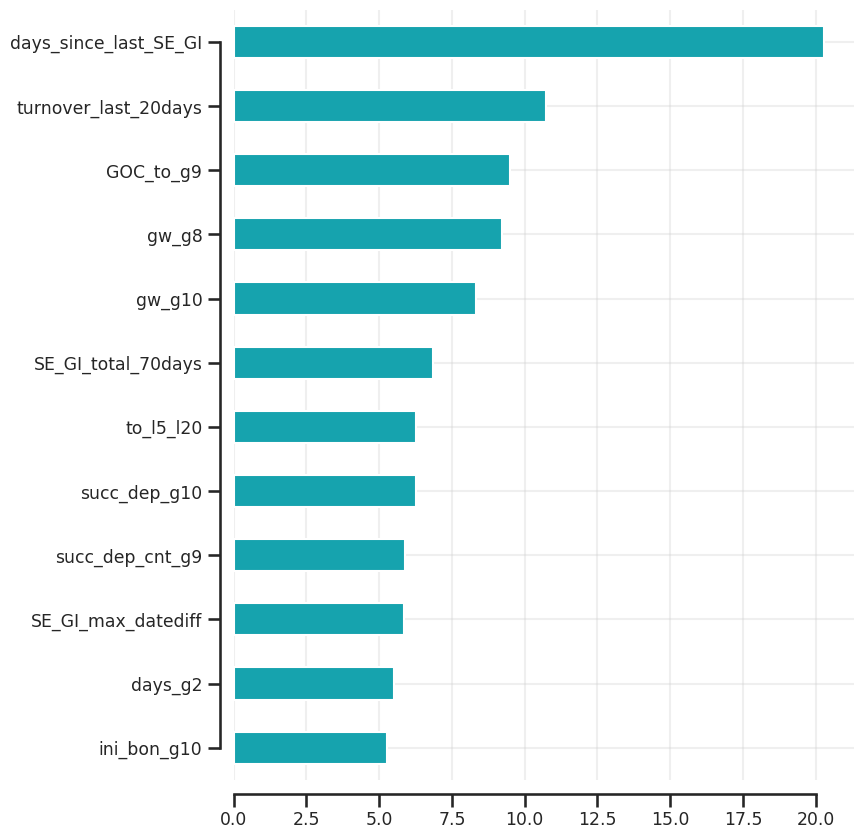

In [21]:
# Show best features
best_features = [feat.split('__')[1] for feat in model_pipeline['classifier'].feature_names_]
print(best_features)
feat_importances = pd.Series(
    model_pipeline['classifier'].feature_importances_,
    index=best_features
).sort_values()

feat_importances.plot.barh(figsize=(8,10))
plt.yticks(size='small')
plt.xticks(size='small')
sns.despine(trim=True, offset=10)
plt.show()